## Ethiopia Nutrition Adequacy



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Demand Analysis for Ethopia, 2018-2019



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ethiopia example that I wish to work
through.



In [2]:
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'

In [4]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'
# Change 'Ethiopia_Data' to key of your own sheet in Sheets, above
r = read_sheets(Ethiopia,sheet='Food Expenditures (2018-19)')
r['i'] = r['i'].astype(str)
r = r.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[r.index.levels[-1]].T

# Household characteristics
d = read_sheets(Ethiopia,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
#r = r.T.groupby(['i','t','m','j']).sum()
r = r.groupby(['i', 't', 'm', 'j']).sum(numeric_only=True)
r = r.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
v = np.log(r)

d = d[d['t'] == '2018-19']
d.set_index(['i','t','m'],inplace=True)

In [5]:
d.groupby('t').mean()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
t,,,,,,,,,,,,,,,
2018-19,0.216248,0.320384,0.286263,0.280798,0.53678,0.428508,0.173855,0.224963,0.316987,0.293205,0.26647,0.424225,0.402659,0.186706,1.302566


In [11]:
from cfe import Regression
import cfe
result1 = Regression(y=v,d=d)

In [12]:
result1.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.722784
                                     Barley       25.973461
                                     Beef        163.760280
                                     Beetroot     10.094725
                                     Berbere      18.426590
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.228985
                                     Tea           6.651267
                                     Teff         66.335750
                                     Tomato        7.975301
                                     Wheat        22.549419
Length: 191958, dtype: float64

<Axes: xlabel='vhat', ylabel='v'>

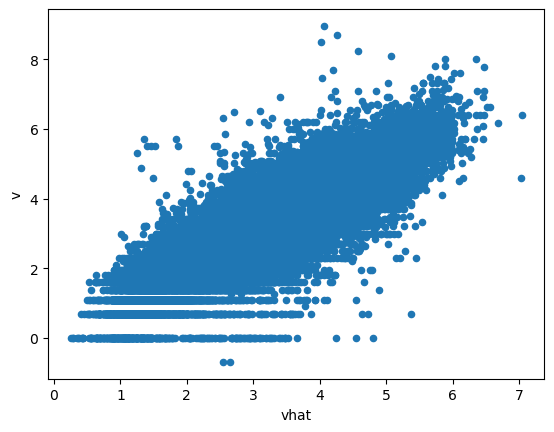

In [13]:
%matplotlib inline
jf = pd.DataFrame({'v':v,'vhat':result1.get_predicted_log_expenditures()})
jf.plot.scatter(x='vhat',y='v')

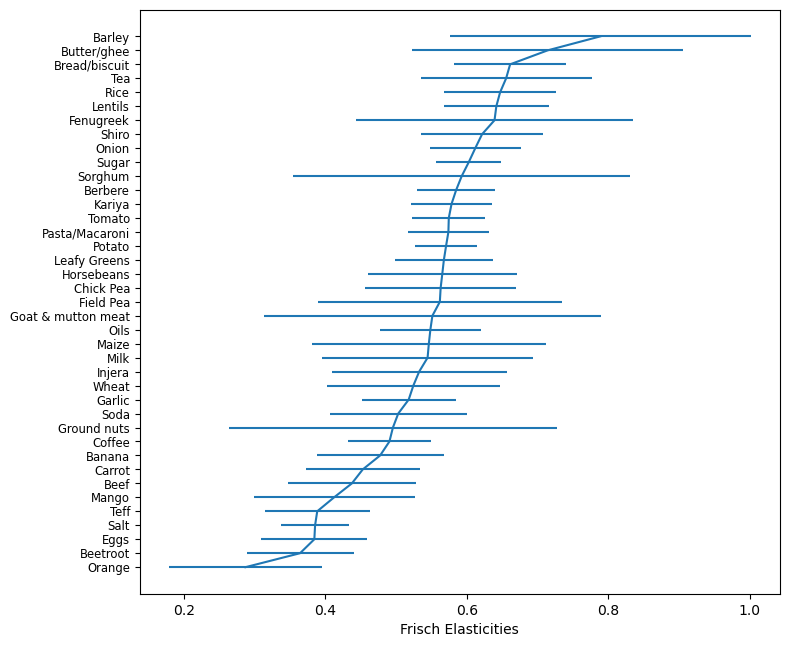

In [14]:
ar = result1.graph_beta()

In [15]:
result1.get_beta()

j
Banana                0.477468
Barley                0.788497
Beef                  0.437551
Beetroot              0.364255
Berbere               0.584863
Bread/biscuit         0.661144
Butter/ghee           0.714137
Carrot                0.452914
Chick Pea             0.562964
Coffee                0.490597
Eggs                  0.384479
Fenugreek             0.639107
Field Pea             0.561824
Garlic                0.517825
Goat & mutton meat    0.551291
Ground nuts           0.495533
Horsebeans            0.565291
Injera                0.532608
Kariya                0.578336
Leafy Greens          0.567523
Lentils               0.641650
Maize                 0.546274
Mango                 0.412395
Milk                  0.544517
Oils                  0.548439
Onion                 0.611916
Orange                0.287136
Pasta/Macaroni        0.573919
Potato                0.570635
Rice                  0.647001
Salt                  0.385525
Shiro                 0.621536
Soda  

In [16]:
result1.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,-0.000223,-0.071820,-0.004488,0.008525,0.126822,0.139662,0.137181,0.020005,-0.085434,-0.055332,-0.031909,0.039605,0.221848,-0.048584,0.199641,3.184720
Barley,0.123631,0.015264,0.175775,0.077300,-0.024047,0.050901,0.119388,-0.137367,0.057757,-0.067983,0.086654,0.091864,-0.010543,0.118789,0.315278,3.279068
Beef,-0.077923,-0.166990,-0.061130,0.088782,0.054320,0.078641,0.094031,-0.053129,-0.072109,-0.101158,0.003401,0.014935,0.128632,0.035798,0.327651,5.249297
Beetroot,-0.037668,-0.010173,0.029583,0.049985,0.031633,0.008869,-0.033093,0.025121,0.039359,0.023534,0.103666,0.094776,0.058950,-0.064471,0.107883,2.567754
Berbere,-0.051770,-0.078390,-0.061653,0.010211,0.076010,0.112779,0.024342,-0.016952,-0.041730,-0.068965,-0.053570,0.010489,0.098185,-0.102997,0.202773,3.278178
Bread/biscuit,-0.109215,-0.126816,-0.064790,-0.049173,-0.035787,-0.062688,-0.061074,-0.110885,-0.055362,-0.000541,0.002074,-0.017882,0.083185,-0.067692,0.561302,3.353942
Butter/ghee,-0.034372,-0.027324,-0.008015,-0.071748,-0.001681,-0.016446,-0.062996,0.007327,-0.185239,-0.118303,0.057603,-0.151067,-0.030623,-0.083604,0.378682,4.061405
Carrot,-0.114253,-0.069433,-0.013742,0.116337,0.092286,0.078432,-0.040475,-0.053034,0.055146,-0.027860,0.006346,-0.040555,0.075077,-0.033651,0.198904,2.586219
Chick Pea,-0.066605,0.028546,0.058243,0.008947,-0.029816,-0.035917,0.036748,-0.074359,0.026539,-0.030653,0.067405,0.024487,-0.017291,-0.018822,0.379831,3.167594


<Axes: ylabel='Density'>

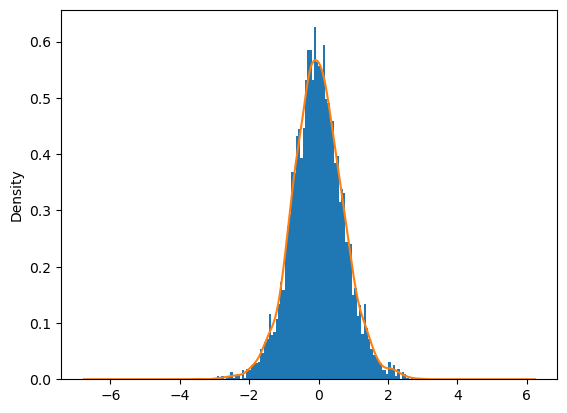

In [18]:
ar = result1.get_w().plot.hist(bins=100,density=True)
result1.get_w().plot.kde(ax=ar)

In [19]:
result1.to_pickle('ethiopia_estimate1516.rgsn')
result1 = cfe.regression.read_pickle('ethiopia_estimate1516.rgsn')

In [20]:
rhat = result1.predicted_expenditures()

# Total food expenditures per household
rbar = rhat.groupby(['i','t','m']).sum()

# Reference budget
rref = rbar.quantile(0.5)  # Household at 0.5 quantile is median

In [21]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result1.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Teff Demanded')

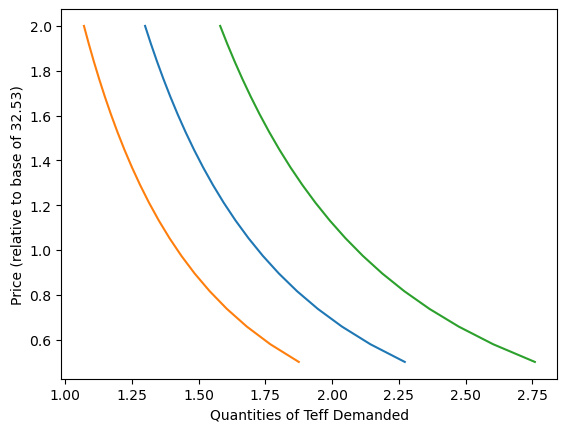

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Teff'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result1.demands(rref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result1.demands(rbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result1.demands(rbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

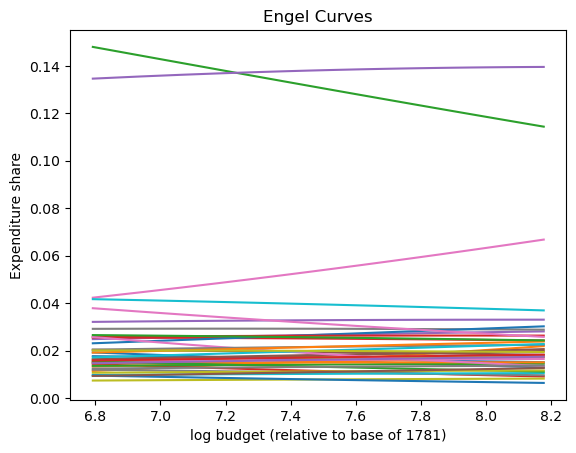

In [23]:
fig,ar = plt.subplots()

ar.plot(np.log(scale*rref),[result1.expenditures(s*rref,pbar)/(s*rref) for s in scale])
ar.set_xlabel(f'log budget (relative to base of {rref:.0f})')
ar.set_ylabel(f'Expenditure share')
ar.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

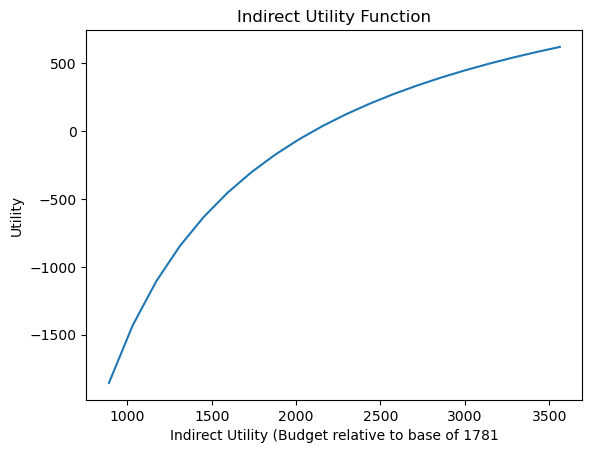

In [24]:
fig,ax = plt.subplots()

ax.plot(scale*rref,[result1.indirect_utility(s*rref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {rref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# Nutrient Ratios for Ethopia, 2018-2019

In [25]:
InputFiles = {'Expenditures':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Expenditures (2018-19)'),
              'Prices':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Prices (2018-19)'),
              'HH Characteristics':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Household Characteristics'),
              'FCT':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [26]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

## important to keep the type of household id value as str.
x['i'] = x['i'].astype(str)

x = x.set_index(['i','t','m', 'j'])


# x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
q = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in q.columns:  # Supply "market" indicator if missing
    q['m'] = 1

q = q[q['u'] == 'Kg']
q = q.drop(columns = ['u'])
q = q.set_index(['t','m', 'j'])

q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.rename(columns={'index':'j'})
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [27]:
result2 = cfe.Regression(y=np.log(x['Expenditure']),d=z)
result2.get_beta().sort_values(ascending=False) # Check sanity...

j
Barley                0.788497
Butter/ghee           0.714137
Bread/biscuit         0.661144
Tea                   0.655502
Rice                  0.647001
Lentils               0.641650
Fenugreek             0.639107
Shiro                 0.621536
Onion                 0.611916
Sugar                 0.602717
Sorghum               0.592757
Berbere               0.584863
Kariya                0.578336
Tomato                0.574467
Pasta/Macaroni        0.573919
Potato                0.570635
Leafy Greens          0.567523
Horsebeans            0.565291
Chick Pea             0.562964
Field Pea             0.561824
Goat & mutton meat    0.551291
Oils                  0.548439
Maize                 0.546274
Milk                  0.544517
Injera                0.532608
Wheat                 0.524379
Garlic                0.517825
Soda                  0.503051
Ground nuts           0.495533
Coffee                0.490597
Banana                0.477468
Carrot                0.452914
Beef  

In [39]:
result2.to_pickle('./foo.pickle')

In [40]:
result2 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...
xhat = result2.predicted_expenditures()
# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/q['Price'].unstack('j')).dropna(how='all')
# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [46]:
use = fct.index.intersection(qhat.columns)
nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean() 

n
Energy          85619.701784
Protein          2788.874698
Vitamin A       30657.669391
Vitamin D         164.809077
Vitamin E         233.993878
Vitamin C        2288.261339
Vitamin B-6        80.089942
Vitamin B-12      199.588358
Calcium         28147.902072
Magnesium       20477.762998
Iron              935.701002
Zinc              468.253444
Fiber                    NaN
Folate                   NaN
Carbohydrate             NaN
Niacin                   NaN
Phosphorus               NaN
Potassium                NaN
Riboflavin               NaN
Thiamin                  NaN
Vitamin K                NaN
dtype: float64

In [47]:
z.columns = [
    col.replace('Females', 'F')
       .replace('Males', 'M')
       .replace('51-99', '51+')
    for col in z.columns
]

In [48]:
z = z[rdi.columns.tolist()]
hh_rdi = z@rdi.T
hh_rwi = hh_rdi*7

In [49]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
#nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
nutrient_ratio = (nutrients[use_nutrients] / hh_rwi[use_nutrients].where(hh_rwi[use_nutrients] != 0)).dropna()


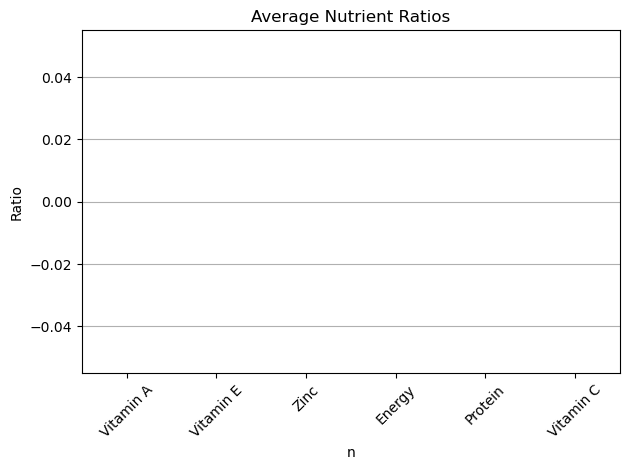

In [53]:
selected_nutrients = ['Vitamin A', 'Vitamin E', 'Zinc', 'Energy', 'Protein', 'Vitamin C']
nutrient_means = nutrient_ratio[selected_nutrients].mean()
nutrient_means.plot(kind='bar')
plt.title('Average Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()